# Pipeline

In [ ]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button

%matplotlib inline
%matplotlib widget
%load_ext autoreload
%autoreload 2

## 1D Cases

In [ ]:
hole = np.array([-1, 1])
obj = np.array([-0.3, 1.3])
# initial_guess_left = scipy.stats.norm(hole[0], 0.5)
initial_guess_left = scipy.stats.norm(obj[0], 0.1)
# initial_guess_right = scipy.stats.norm(hole[1], 0.5)
initial_guess_right = scipy.stats.norm(obj[1], 0.1)
mean = np.array([initial_guess_left.mean(), initial_guess_right.mean()])
disp = mean.mean()
mean -= disp
obj -= disp
std = np.array([initial_guess_left.std(), initial_guess_right.std()])
guess = [scipy.stats.norm(mean[i], std[i]) for i in range(2)]

In [ ]:
fig = plt.figure(figsize=(15,5))

# Plot scene
x_grid = np.linspace(-2, 2, 100)

ax = fig.add_subplot(1, 3, 1)
mask = x_grid>hole[1] 
ax.plot(x_grid[mask], np.zeros(mask.sum()), 'r', linewidth=10)
mask = x_grid<hole[0] 
ax.plot(x_grid[mask], np.zeros((mask).sum()), 'r', linewidth=10)
mask = (x_grid>obj[0]) & (x_grid<obj[1])
ax.plot(x_grid[mask], np.ones((mask).sum())*0.01, 'b', linewidth=10)

# plot initial guess
for i in range(2):
  mask = (x_grid<(mean[i]+0.5)) & (x_grid > mean[i]-0.5)
  color = guess[i].pdf(x_grid[mask])
  ax.scatter(x_grid[mask], np.ones(mask.sum())*0.005, c=color, cmap='viridis', linewidths=1)

ax.title.set_text('current state')


# Plot Two side distribution
for i in range(2):
  ax = fig.add_subplot(1, 3, i+2)
  ax.plot(x_grid, guess[i].pdf(x_grid))
  ax.title.set_text(f'Distance to {i} Side')


In [ ]:
fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(1, 2, 1)
ax.errorbar([0,1], [mean[0]-hole[0], hole[1]-mean[1]], std, linestyle='None', marker='^')
ax.title.set_text('Surrogate Function')
ax.set_ylabel('Distance to Hole')

ax = fig.add_subplot(1, 2, 2)
ax.scatter([0,1], [initial_guess_left.std(), initial_guess_right.std()])
ax.title.set_text('Acquisition Function')

# 2D Cases

In [ ]:
from scipy.ndimage import gaussian_filter1d
import gpytorch
import torch
from tqdm import trange

In [ ]:
n_sample = 36
X = np.linspace(0, (1+1/n_sample)*2*np.pi, n_sample+1).reshape(-1,1)[:-1]
y = np.ones(X.shape[0])
for i in range(-3, 3):
  i %= 36
  y[i] = 1/np.abs(np.cos(X[i]))
for i in range(3, 15):
  y[i] = 0.57735/np.abs(np.cos(np.pi/2-X[i]))
for i in range(15, 21):
  y[i] = 1/np.abs(np.cos(X[i]))
for i in range(21, 33):
  y[i] = 0.57735/np.abs(np.cos(3*np.pi/2-X[i]))

hole_half_size = 0.7

In [ ]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1, 2, 1)
ysmoothed = gaussian_filter1d(y, sigma=1)
ax.plot(X, y)
ax.plot(X, ysmoothed)
ax = fig.add_subplot(1, 2, 2, projection='polar')
ax.plot(X, y)
ax.plot(X, ysmoothed)
ax.scatter(0, hole_half_size, color='red',)
ax.scatter(np.pi, hole_half_size, color='red')
y = ysmoothed

In [ ]:
y_mean = y.mean()
y_std = y.std()
y_normed = (y-y_mean)/y_std

Start from Here

In [ ]:
train_index = [0, 18, 9, 13, 4]
train_index = np.append(train_index, 35)
x_train = torch.tensor(X[train_index])
y_train = torch.tensor(y_normed[train_index])

In [ ]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
  def __init__(self, train_x, train_y, likelihood):
    super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
    self.mean_module = gpytorch.means.ConstantMean()
    self.covar_module = gpytorch.kernels.ScaleKernel(
      gpytorch.kernels.RBFKernel())

  def forward(self, x):
    mean_x = self.mean_module(x)
    covar_x = self.covar_module(x)
    return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(noise=torch.zeros_like(y_train, dtype=torch.float64))
model = ExactGPModel(x_train, y_train, likelihood)


In [ ]:
hypers = {
  'covar_module.base_kernel.lengthscale': torch.tensor(0.4),
}
model_params = model.initialize(**hypers)

In [ ]:
model.train()
likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

train_num = 20
for i in (pbar := trange(train_num)):
  # Zero gradients from previous iteration
  optimizer.zero_grad()
  # Output from model
  output = model(x_train)
  loss = -mll(output, y_train)
  loss.backward()
  pbar.set_description(f'Iter {i+1}/{train_num} - Loss: {loss.item():.3f}, lengthscale: {model.covar_module.base_kernel.lengthscale.item():.3f}')
  optimizer.step()

In [32]:

n_eval = 120
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
  x_pred = torch.linspace(0, 2*torch.pi, n_eval+1, dtype=torch.float64)
  observed_pred = likelihood(model(x_pred))

y_pred = (observed_pred.mean*y_std+y_mean).numpy()
y_pred_std = (observed_pred.stddev*y_std).numpy()
y_lower, y_upper = observed_pred.confidence_region()
y_lower = y_lower.numpy() * y_std + y_mean
y_upper = y_upper.numpy() * y_std + y_mean

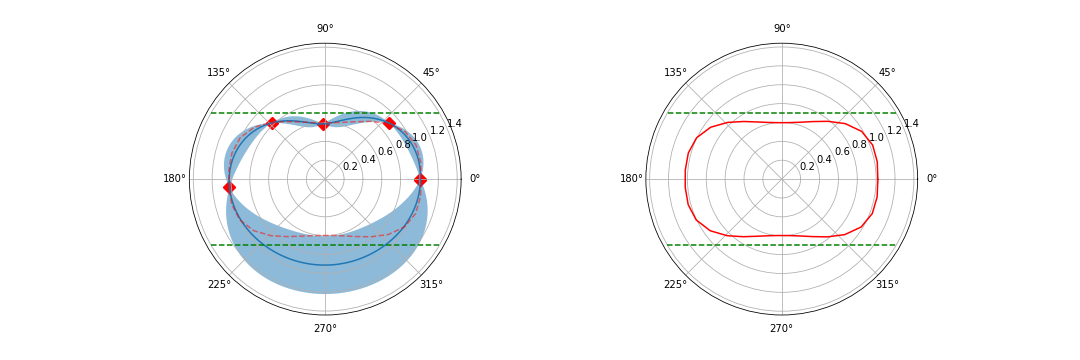

In [75]:
x_line = np.linspace(np.pi/6, np.pi*5/6, 20)
y_line = hole_half_size / np.sin(x_line)

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1, 2, 1, projection='polar')
ax.scatter(x_train.numpy(), y_train.numpy()*y_std+y_mean, c='r', marker='x', linewidth=10)
ax.fill_between(
  x_pred.flatten(),
  y_lower,
  y_upper,
  alpha=0.5,
  label=r"95% confidence interval",
)
ax.plot(x_pred, y_pred)
ax.plot(X, y, 'r--', markersize=15, alpha=0.5)
ax.plot(x_line, y_line, 'g--', markersize=15)
ax.plot(x_line+np.pi, y_line, 'g--', markersize=15)

ax = fig.add_subplot(1, 2, 2, projection='polar')
ax.plot(X, y, 'r', markersize=15)
ax.plot(x_line, y_line, 'g--', markersize=15)
ax.plot(x_line+np.pi, y_line, 'g--', markersize=15)

In [87]:
# calculate the distance to the hole
# The things we need to do is convert gaussian distribution in polar coordinate to cartesian coordinate
# and then calculate the distance to the hole
# p(x,y) = 1/r*p(r,theta)

obj_orn = np.pi/4

# left side
if isinstance(x_pred, torch.Tensor):
  x_pred = x_pred.flatten().numpy()
x_pred_rot = (x_pred - obj_orn) % (2*np.pi)
mask_left = x_pred_rot < np.pi

x_pred_left = x_pred_rot[mask_left]
y_pred_left = y_pred[mask_left]
mu_2left = hole_half_size - y_pred_left * np.sin(x_pred_left)
std_2left = y_pred_std[mask_left] * np.sin(x_pred_left)

# right side
mask_right = x_pred_rot > np.pi
x_pred_right = x_pred_rot[mask_right]
y_pred_right = y_pred[mask_right]
mu_2right = hole_half_size + y_pred_right * np.sin(x_pred_right)
std_2right = - y_pred_std[mask_right] * np.sin(x_pred_right)

dist = np.ones_like(y_pred)*0.63
dist[mask_left] = mu_2left
dist[mask_right] = mu_2right
dist_std = np.zeros_like(y_pred)
dist_std[mask_left] = std_2left
dist_std[mask_right] = std_2right

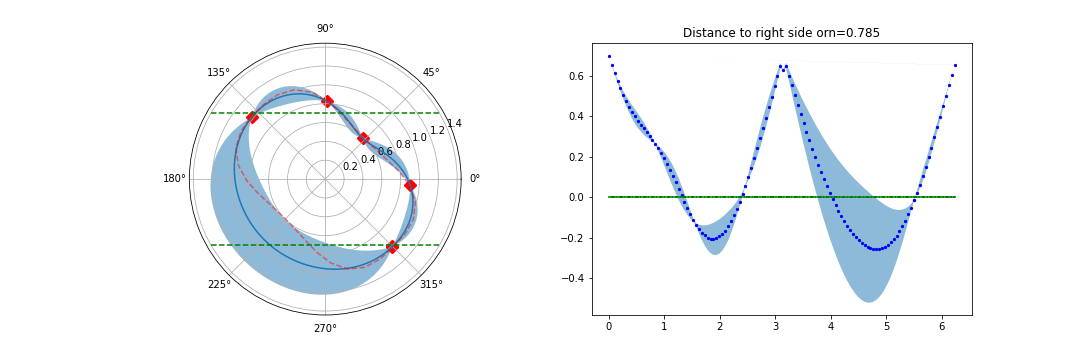

In [103]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(1,3,1 ,projection='polar')
ax.scatter(x_train.numpy()-obj_orn, y_train.numpy()*y_std+y_mean, c='r', marker='x', linewidth=10)
ax.fill_between(
  x_pred_rot,
  y_lower,
  y_upper,
  alpha=0.5,
  label=r"95% confidence interval",
)
ax.plot(x_pred_rot, y_pred)
ax.plot(X-obj_orn, y, 'r--', markersize=15, alpha=0.5)
ax.plot(x_line, y_line, 'g--', markersize=15)
ax.plot(x_line+np.pi, y_line, 'g--', markersize=15)

ax = fig.add_subplot(1, 3, 2)
ax.fill_between(
  x_pred_rot,
  dist - dist_std*1.95,
  dist + dist_std*1.95,
  alpha=0.5,
  label=r"95% confidence interval",
)
ax.scatter(x_pred_rot, dist, s=5, c='b')
ax.plot(x_pred_rot, np.zeros_like(x_pred), 'g--', markersize=15)
ax.title.set_text(f'Distance to right side orn={obj_orn:.3f}')



In [ ]:
# get minimum distance from the distribution. 

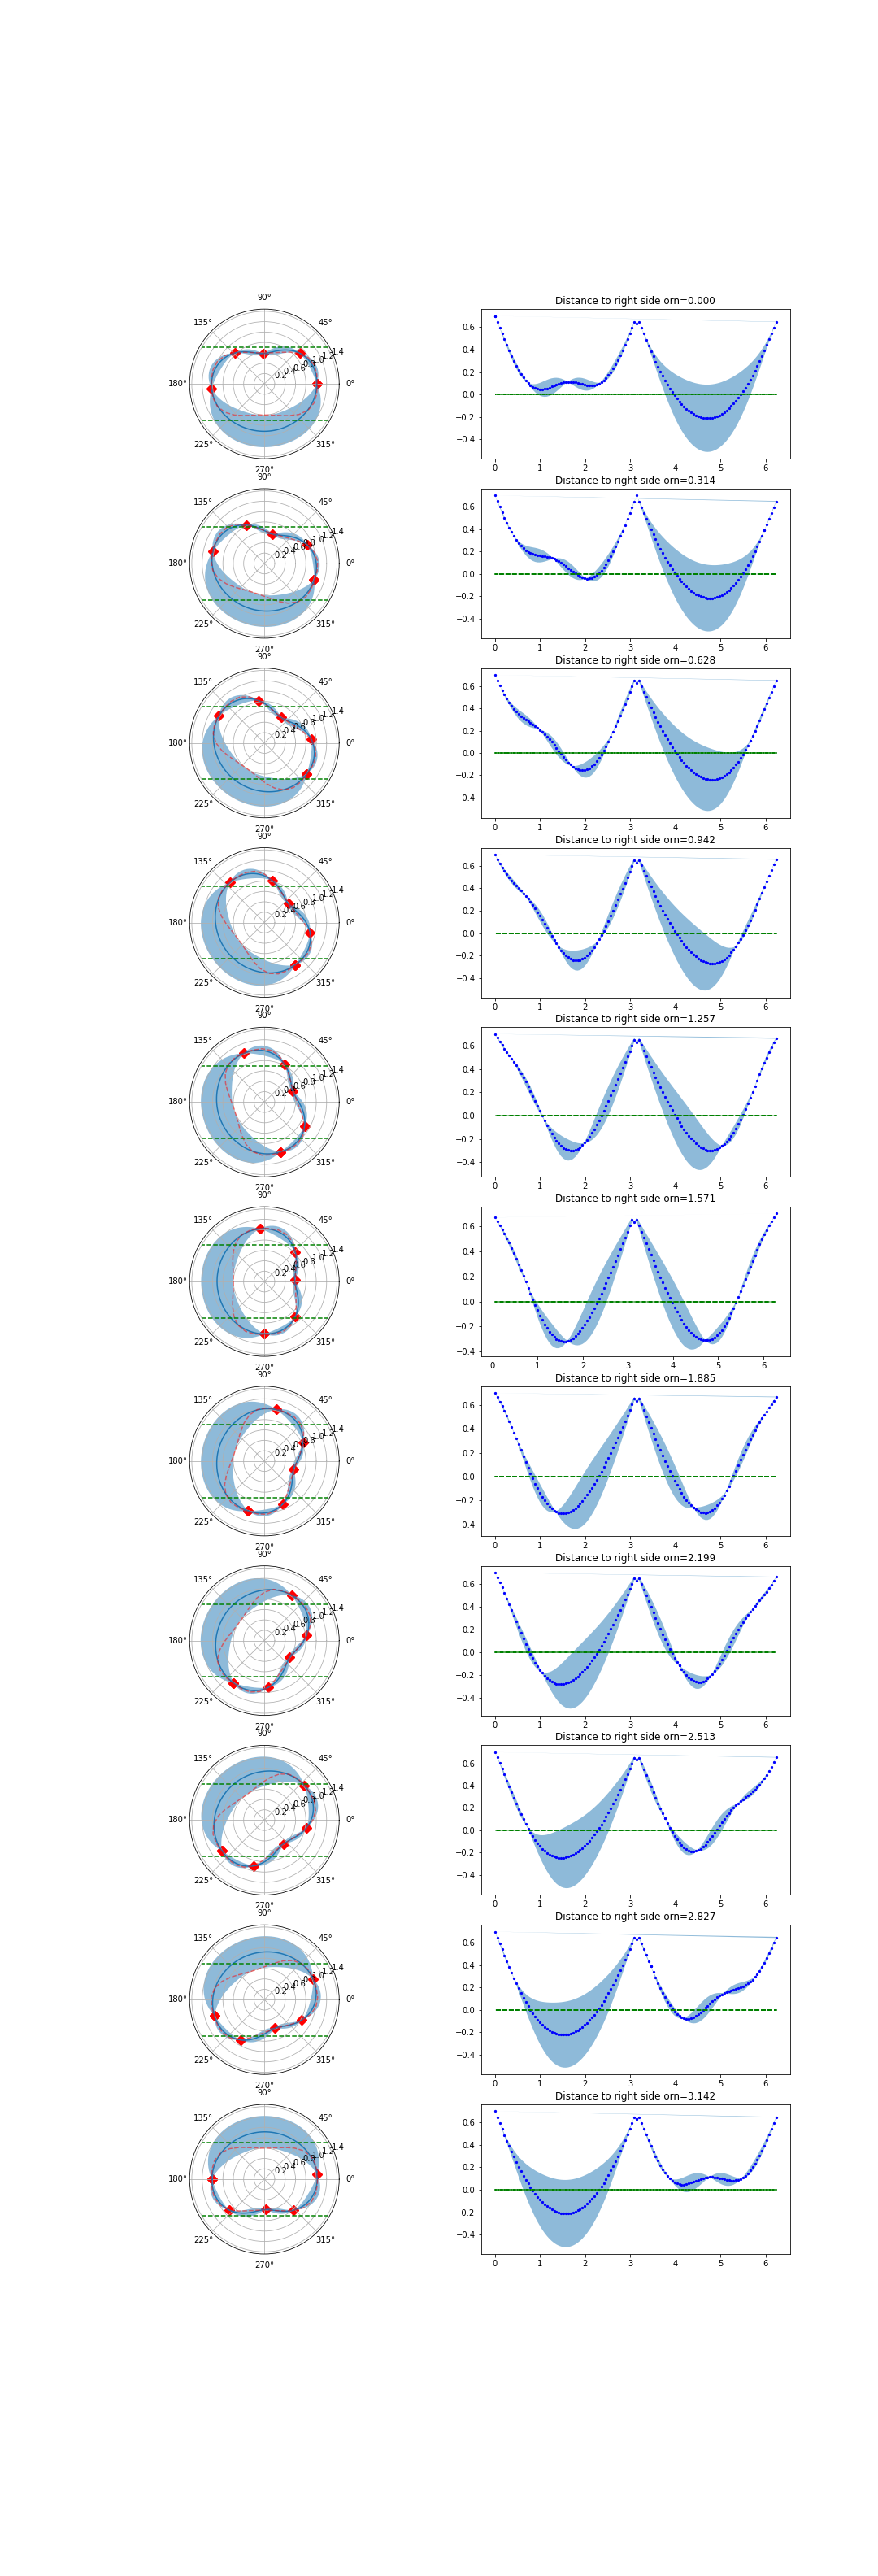

In [104]:
n_sample = 11
fig = plt.figure(figsize=(15,4*n_sample))
for i, obj_orn in enumerate(np.linspace(0, np.pi, n_sample)):
  # left side
  if isinstance(x_pred, torch.Tensor):
    x_pred = x_pred.flatten().numpy()
  x_pred_rot = (x_pred - obj_orn) % (2*np.pi)
  mask_left = x_pred_rot < np.pi

  x_pred_left = x_pred_rot[mask_left]
  y_pred_left = y_pred[mask_left]
  mu_2left = hole_half_size - y_pred_left * np.sin(x_pred_left)
  std_2left = y_pred_std[mask_left] * np.sin(x_pred_left)

  # right side
  mask_right = x_pred_rot > np.pi
  x_pred_right = x_pred_rot[mask_right]
  y_pred_right = y_pred[mask_right]
  mu_2right = hole_half_size + y_pred_right * np.sin(x_pred_right)
  std_2right = - y_pred_std[mask_right] * np.sin(x_pred_right)

  dist = np.ones_like(y_pred)*0.63
  dist[mask_left] = mu_2left
  dist[mask_right] = mu_2right
  dist_std = np.zeros_like(y_pred)
  dist_std[mask_left] = std_2left
  dist_std[mask_right] = std_2right

  ax = fig.add_subplot(n_sample,2,2*i+1,projection='polar')
  ax.scatter(x_train.numpy()-obj_orn, y_train.numpy()*y_std+y_mean, c='r', marker='x', linewidth=10)
  ax.fill_between(
    x_pred_rot,
    y_lower,
    y_upper,
    alpha=0.5,
    label=r"95% confidence interval",
  )
  ax.plot(x_pred_rot, y_pred)
  ax.plot(X-obj_orn, y, 'r--', markersize=15, alpha=0.5)
  ax.plot(x_line, y_line, 'g--', markersize=15)
  ax.plot(x_line+np.pi, y_line, 'g--', markersize=15)

  ax = fig.add_subplot(n_sample, 2, 2*i+2)
  ax.fill_between(
    x_pred_rot,
    dist - dist_std*1.95,
    dist + dist_std*1.95,
    alpha=0.5,
    label=r"95% confidence interval",
  )
  ax.scatter(x_pred_rot, dist, s=5, c='b')
  ax.plot(x_pred_rot, np.zeros_like(x_pred), 'g--', markersize=15)
  ax.title.set_text(f'Distance to right side orn={obj_orn:.3f}')